# Imports

In [14]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
from clean import PCBCCleaner, DrawPointAssayCleaner
import plotter

output_dir = "../outputs/het_analysis_wrt_time_compare_dp_pcbc/"
SAVE = True

plt.rcParams.update(
    {
        'font.size': 18
    }
)

# %matplotlib widget

# Data Input and Cleaning

In [15]:
pcbc_df = PCBCCleaner.get_processed_data()
assay_df = DrawPointAssayCleaner.get_processed_data()

# Group and Output

## Grouping

In [16]:
ids = list(pcbc_df['dhid'].unique())
elements = [
    'CU',
    'AU'
]

### PCBC

In [17]:
pcbc_igs, pcbc_timeslices = {}, {}

for id in ids:
    dp_timeslices = {} 

    filtered_df = pcbc_df.query('dhid == @id').dropna(subset=elements).reset_index(drop=True)

    indices = filtered_df.index.to_list()

    dp_ig = {} # instantaneous grade
    for index in indices:
        date = filtered_df.iloc[index]['date']
        dp_timeslices[date] = {}
        
        for element in elements:
            if element not in dp_ig:
                dp_ig[element] = []
            
            dp_ig[element].append(filtered_df[element].loc[index])
            
            dp_timeslices[date][element] = HetAnalysis(
                f'{id}_{element}_{date}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    pcbc_timeslices[id] = dp_timeslices
    pcbc_igs[id] = dp_ig

### DP Assay

In [18]:
assay_igs, assay_timeslices = {}, {}

for id in ids:
    dp_timeslices = {} 

    filtered_df = assay_df.query('dhid == @id').dropna(subset=elements).reset_index(drop=True)

    indices = filtered_df.index.to_list()

    dp_ig = {} # instantaneous grade
    for index in indices:
        date = filtered_df.iloc[index]['date']
        dp_timeslices[date] = {}
        
        for element in elements:
            if element not in dp_ig:
                dp_ig[element] = []
            
            dp_ig[element].append(filtered_df[element].loc[index])
            
            dp_timeslices[date][element] = HetAnalysis(
                f'{id}_{element}_{date}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    assay_timeslices[id] = dp_timeslices
    assay_igs[id] = dp_ig

## Output

### Individual Graphs

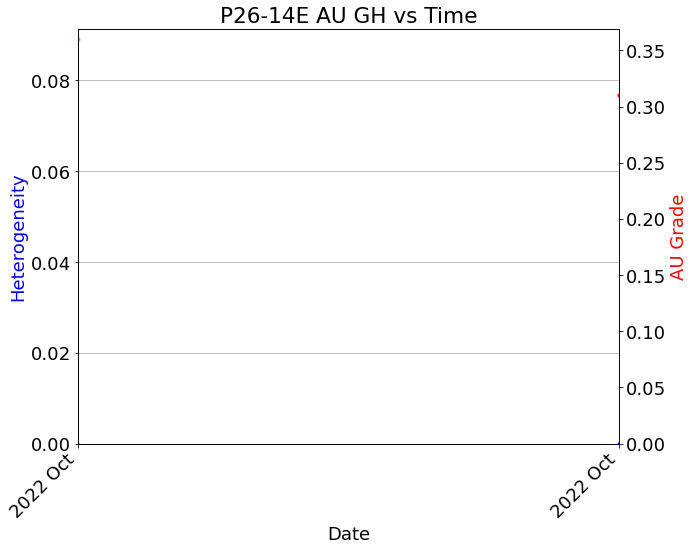

In [21]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    
    for id in ids:
        save_loc = output_dir + f'{id}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
            
        pcbc_timeslice = pcbc_timeslices[id]
        assay_timeslice = assay_timeslices[id]

        for element in elements:
            pcbc_d, pcbc_h = [], []
            for date, timeslice in pcbc_timeslice.items():
                pcbc_d.append(date)
                pcbc_h.append(timeslice[element].get_heterogeneity())
                
            assay_d, assay_h = [], []
            for date, timeslice in assay_timeslice.items():
                assay_d.append(date)
                assay_h.append(timeslice[element].get_heterogeneity())
                
            fig.clear()
            ax = fig.add_subplot()

            ax.scatter(assay_d, assay_h, c='blue', s=10)
            ax.plot(assay_d, assay_h, c='blue', ls='-')
            
            ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='blue', s=10)
            ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='blue', ls='-')

            ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
            ax.set_xlabel('Date')

            for label in ax.get_xticklabels(which='major'):
                label.set(rotation=45, horizontalalignment='right')

            ax.set_ylim(0)
            ax.set_ylabel('Heterogeneity', c='blue')

            sec_ax = ax.twinx()
            
            pcbc_ig = pcbc_igs[id][element]
            assay_ig = assay_igs[id][element]

            sec_ax.scatter(assay_d, assay_ig, c='red', s=10)
            sec_ax.plot(assay_d, assay_ig, c='red', ls='-')
            
            sec_ax.scatter(pcbc_d, pcbc_ig, alpha=0.4, c='red', s=10)
            sec_ax.plot(pcbc_d, pcbc_ig, alpha=0.2, c='red', ls='-')

            sec_ax.set_ylim(0)
            sec_ax.set_ylabel(f'{element} Grade', c='red')

            ax.set_title(f'{id} {element} GH vs Time')
            
            ax.grid()

            fig.tight_layout()
            fig.savefig(save_loc + f'{id}_{element}.svg', format='svg')